# Installation

In [100]:
pip install pymongo

In [101]:
import pandas as pd
import pymongo as pm
import pprint
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Init

In [102]:
torino_zones = gpd.read_file("TorinoZonescol.geojson")
zones = torino_zones.to_crs("EPSG:4326")

client = pm.MongoClient('bigdatadb.polito.it',
                       ssl=True,
                       authSource = 'carsharing',
                       username = 'ictts',
                       password = 'Ict4SM22!',
                       tlsAllowInvalidCertificates= True)
db = client['carsharing'] #choosse the db to use
ictts_PermanentBookings = db['ictts_PermanentBookings'] #cargo2
ictts_enjoy_PermanentBookings = db['ictts_enjoy_PermanentBookings'] #enjoy


df_IMQ = pd.read_csv("IMQData_Torino.csv") # geneder, age , motivation
df_Trips = pd.read_csv("Trips_OD_TO.csv") # org/dest, departure/ arriv #535k trip records
df_Info = pd.read_csv("Info_TO.csv") # 38 k user, gender, age


#Joining df_trips and df_info
df_Trips = df_Trips.merge(df_Info, on='id_veicolo', how='left')

def pipelinefilter(collection,days_inside,hour_init,hour_final,start_date=None, end_date=None):

    date_filter = {}
    if start_date and end_date:  # Si se especifica un rango de fechas
        date_filter = {
            "init_date": {  # Ajusta el campo según el nombre en tu base de datos
                "$gte": datetime.strptime(start_date, "%Y-%m-%d"),
                "$lt": datetime.strptime(end_date, "%Y-%m-%d")
            }
        }

    # Filtro de horas
    if hour_init > hour_final:  # Para casos como "horas nocturnas"
        hour_filter = {
            "$or": [
                {"hour": {"$gte": hour_init}},
                {"hour": {"$lt": hour_final}}
            ]
        }
    else:  # Para casos diurnos normales
        hour_filter = {"hour": {"$gte": hour_init, "$lt": hour_final}}

    # Pipeline de agregación
    pipeline = [
        {
            "$project": {  # Extrae y calcula los valores necesarios
                "hour": {"$hour": "$init_date"},  # Convierte la fecha a hora
                "day": {"$dayOfWeek": "$init_date"},  # Convierte la fecha a día de la semana
                "init_loc": 1,
                "final_loc": 1,
                "init_date": 1  # Incluye la fecha inicial para filtrado y visualización
            }
        },
        {
            "$match": {  # Aplica los filtros
                **hour_filter,
                "day": {"$in": days_inside},  # Filtra por días de la semana
                **date_filter  # Filtra por rango de fechas si se proporciona
            }
        }
    ]

    # Ejecuta el pipeline en la colección y devuelve los resultados como lista
    collection_res = collection.aggregate(pipeline)
    return list(collection_res)


def assign_zones(df, zones_geojson_path):
    df["start_point"] = df["init_loc"].apply(
        lambda loc: Point(loc['coordinates'][0], loc['coordinates'][1]))

    df["stop_point"] = df["final_loc"].apply(
        lambda loc: Point(loc['coordinates'][0], loc['coordinates'][1]))
    start_gdf = gpd.GeoDataFrame(df, geometry="start_point", crs="EPSG:4326")
    stop_gdf = gpd.GeoDataFrame(df, geometry="stop_point", crs="EPSG:4326")
    #to see if the data is inside of the zones
    start_zones = gpd.sjoin(start_gdf, zones, how="left", predicate="intersects") #intersects to see if is inside de poly or in the line
    stop_zones = gpd.sjoin(stop_gdf, zones, how="left", predicate="intersects")
    # Asignar las zonas al DataFrame original
    df["ORI_ZONE"] = start_zones["zone_id"]  # Cambia 'zone_id' si tu GeoJSON tiene un identificador diferente
    df["DST_ZONE"] = stop_zones["zone_id"]

    # Eliminar filas con valores NaN en ORI_ZONE o DST_ZONE
    df = df.dropna(subset=["ORI_ZONE", "DST_ZONE"]).reset_index(drop=True)

    return df

def compute_distance(matrix_a, matrix_b, metric):
    if metric == 'manhattan':
        return np.sum(np.abs(matrix_a - matrix_b))
    elif metric == 'euclidean':
        return np.sqrt(np.sum((matrix_a - matrix_b)**2))
    else:
        raise ValueError("metric not supported")

#to generate a heatmap
def plot_heatmap(matrix, title="Heatmap"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=False, cmap='coolwarm', cbar=True)
    plt.title(title)
    plt.show()


In [103]:
zones['zone_id'] = ['Q' + str(i+1).zfill(3) for i in range(len(zones))] #create the zones id like the IMQ matrix
zones.count()

,0
fill,23
fill-opacity,23
geometry,23
zone_id,23


a)Compute OD matrices on different periods (weekdays vs weekends, daytime vs night-time).
Is it possible to spot any difference?

b)Consider the same period, compute OD matrices on different dates (e.g., OD matrices of
weekdays in two different weeks). is it possible to spot any difference? How does the
different compare with different periods?

In [104]:
#filt by city and time
#pipelinefilter(collection,days_inside,hour_init,hour_final,start_date=None, end_date=None)
ictts_PermanentBookings.find({"city":"Torino"})
ictts_enjoy_PermanentBookings.find({"city":"Torino"})

# It include from 2017-09-01 to 2017-10-31
ictts_PermanentBookings_weekday = pipelinefilter(ictts_PermanentBookings,[2,3,4,5,6],0,24)
ictts_PermanentBookings_weekend = pipelinefilter(ictts_PermanentBookings,[1,7],0,24)

ictts_PermanentBookings_night = pipelinefilter(ictts_enjoy_PermanentBookings,list(range(1, 8)),18,6)
ictts_PermanentBookings_day = pipelinefilter(ictts_enjoy_PermanentBookings,list(range(1, 8)),6,18)

ictts_PermanentBookings_normal_week = pipelinefilter(ictts_enjoy_PermanentBookings,list(range(1, 8)),0,24,"2017-09-01","2017-09-15")
ictts_PermanentBookings_normal_week_2 = pipelinefilter(ictts_enjoy_PermanentBookings,list(range(1, 8)),0,24,"2017-10-01","2017-10-15")

ictts_PermanentBookings_normal_weekend = pipelinefilter(ictts_enjoy_PermanentBookings,[1,7],0,24,"2017-09-01","2017-09-15")
ictts_PermanentBookings_normal_weekend_2 = pipelinefilter(ictts_enjoy_PermanentBookings,[1,7],0,24,"2017-10-01","2017-10-15")

#enjoy

ictts_enjoy_PermanentBookings_weekday = pipelinefilter(ictts_enjoy_PermanentBookings,[2,3,4,5,6],0,24)


ictts_PermanentBookings_general = pipelinefilter(ictts_PermanentBookings,[1,2,3,4,5,6,7],0,24)
ictts_enjoy_PermanentBookings_general = pipelinefilter(ictts_enjoy_PermanentBookings,[1,2,3,4,5,6,7],0,24)

In [105]:
#Dataframes
df_ictts_PermanentBookings_weekend = pd.DataFrame(ictts_PermanentBookings_weekend)
df_ictts_PermanentBookings_weekday = pd.DataFrame(ictts_PermanentBookings_weekday)
df_ictts_PermanentBookings_night = pd.DataFrame(ictts_PermanentBookings_night)
df_ictts_PermanentBookings_day = pd.DataFrame(ictts_PermanentBookings_day)


df_ictts_PermanentBookings_normal_week = pd.DataFrame(ictts_PermanentBookings_normal_week)
df_ictts_PermanentBookings_normal_week_2 = pd.DataFrame(ictts_PermanentBookings_normal_week_2)

df_ictts_PermanentBookings_normal_weekend = pd.DataFrame(ictts_PermanentBookings_normal_weekend)
df_ictts_PermanentBookings_normal_weekend_2 = pd.DataFrame(ictts_PermanentBookings_normal_weekend_2)


df_ictts_enjoy_PermanentBookings_weekday = pd.DataFrame(ictts_enjoy_PermanentBookings_weekday)


#For point d of point 3
df_ictts_PermanentBookings_general= pd.DataFrame(ictts_PermanentBookings_general)

df_ictts_enjoy_PermanentBookings_general = pd.DataFrame(ictts_enjoy_PermanentBookings_general)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


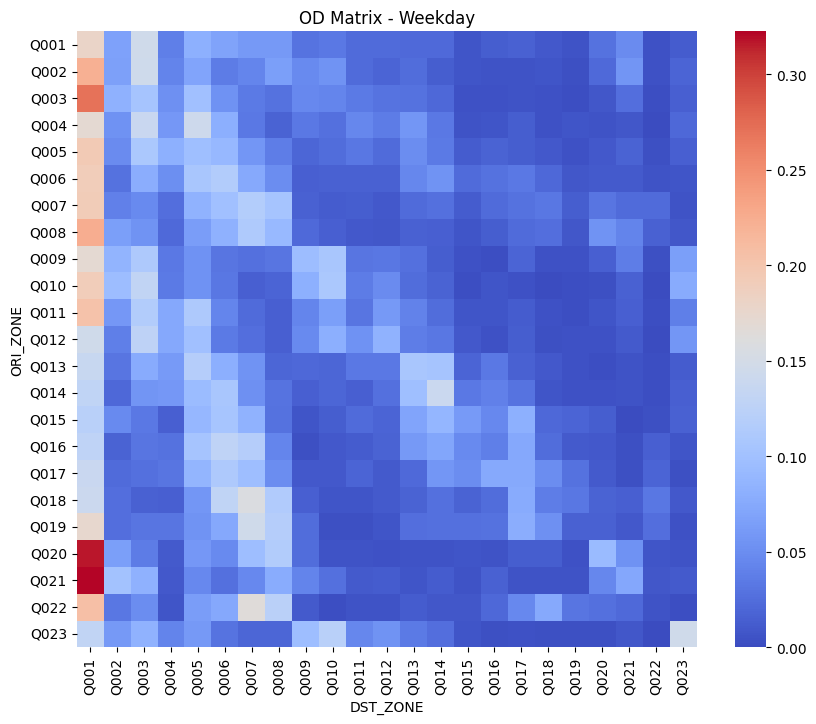

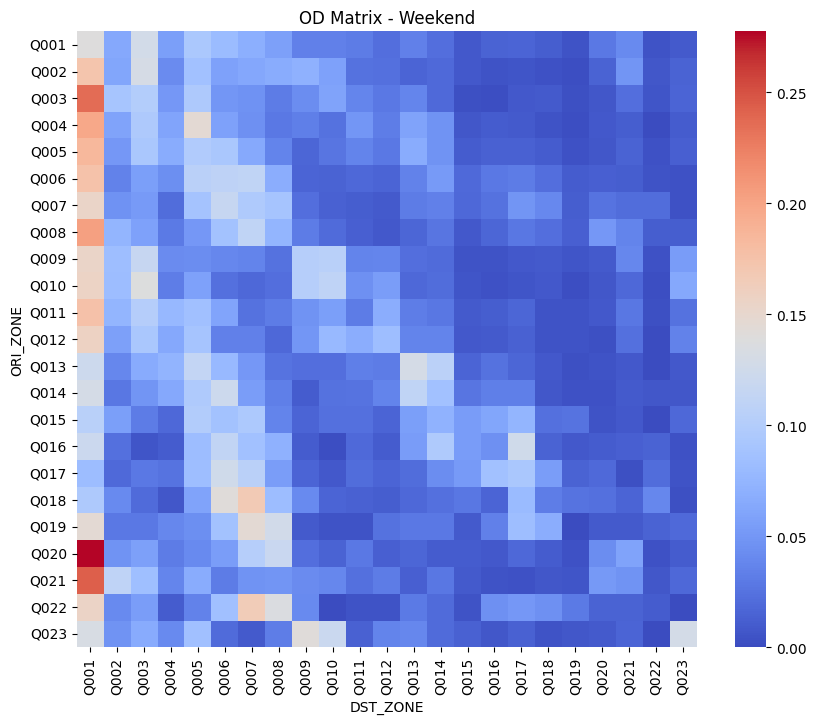

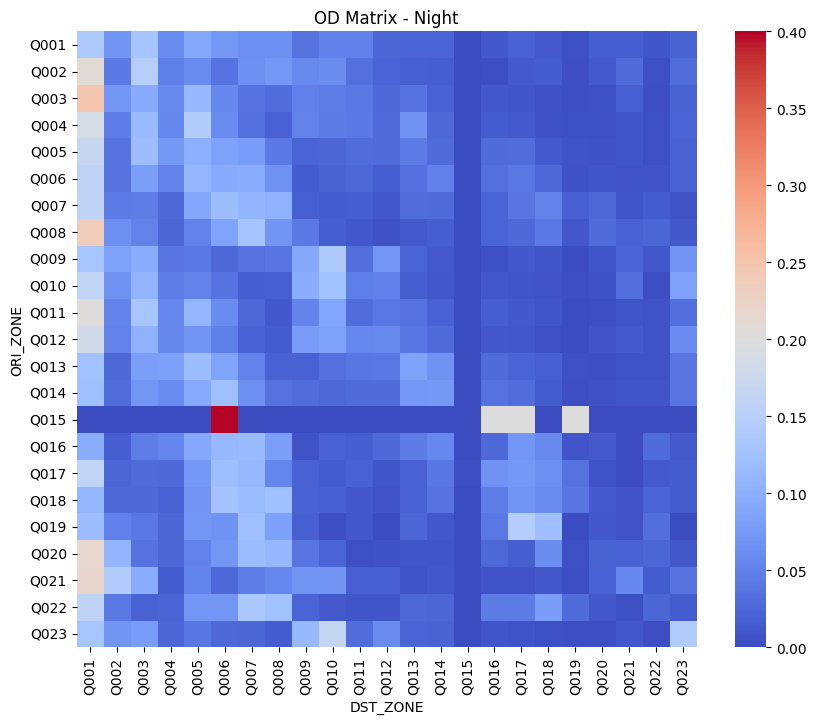

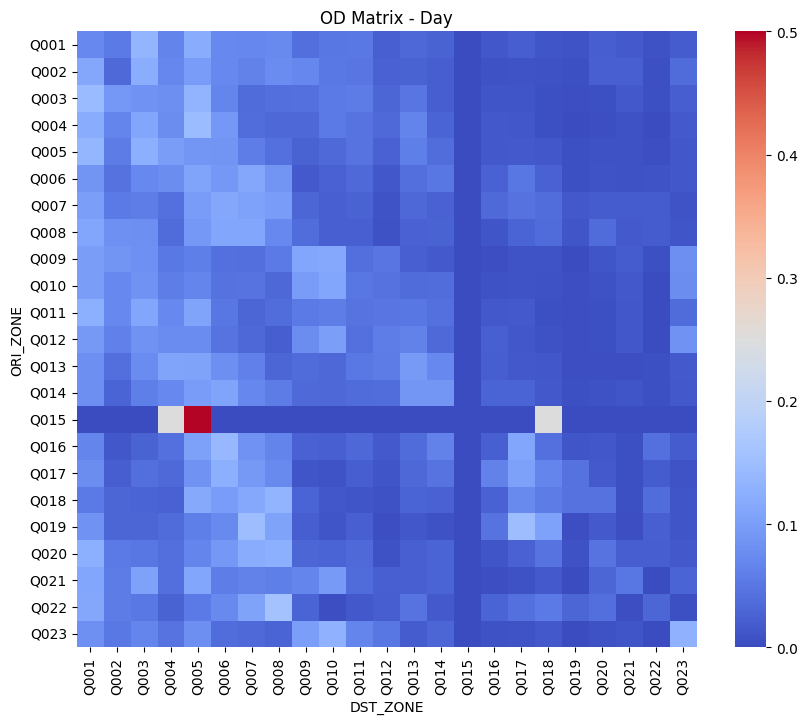

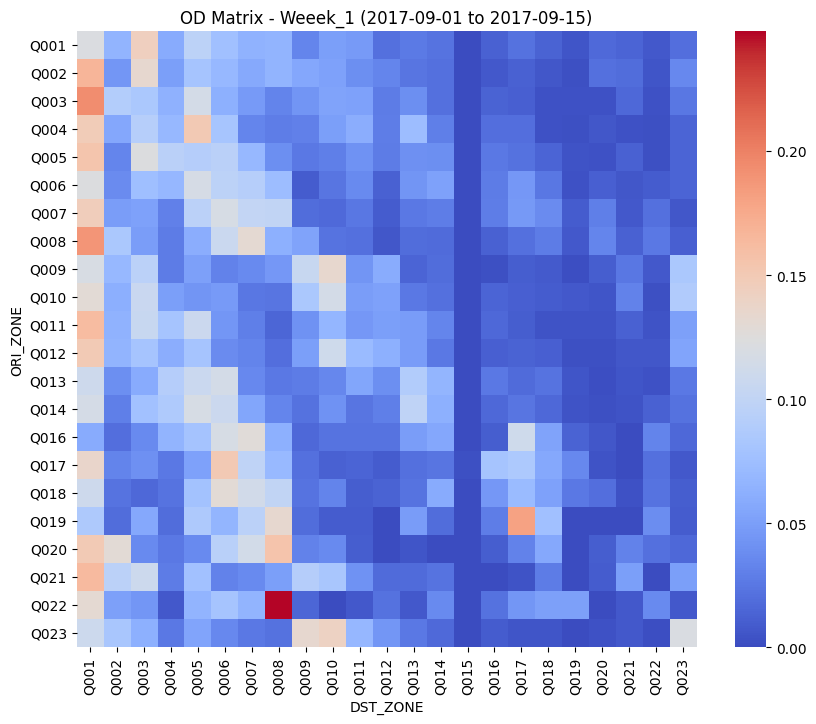

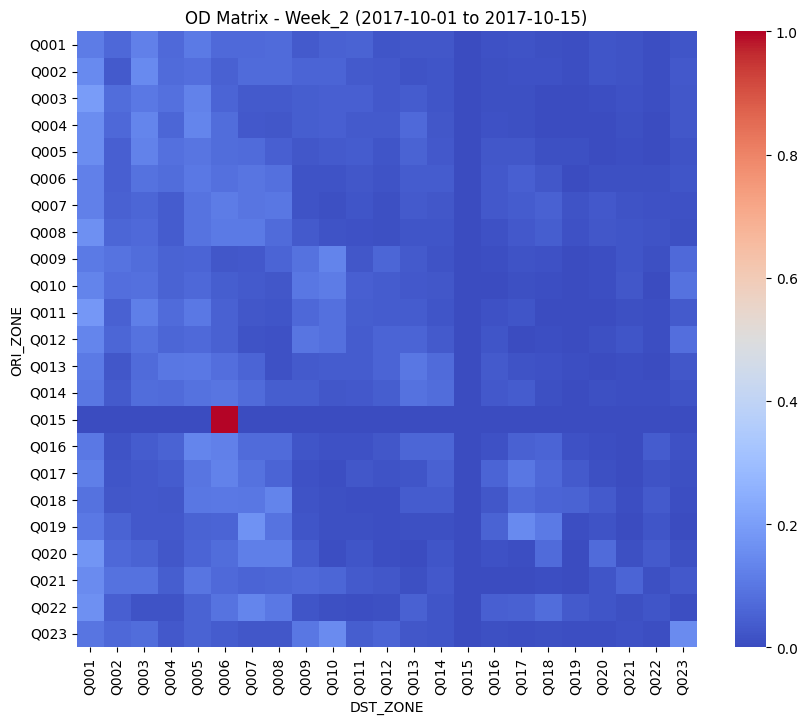

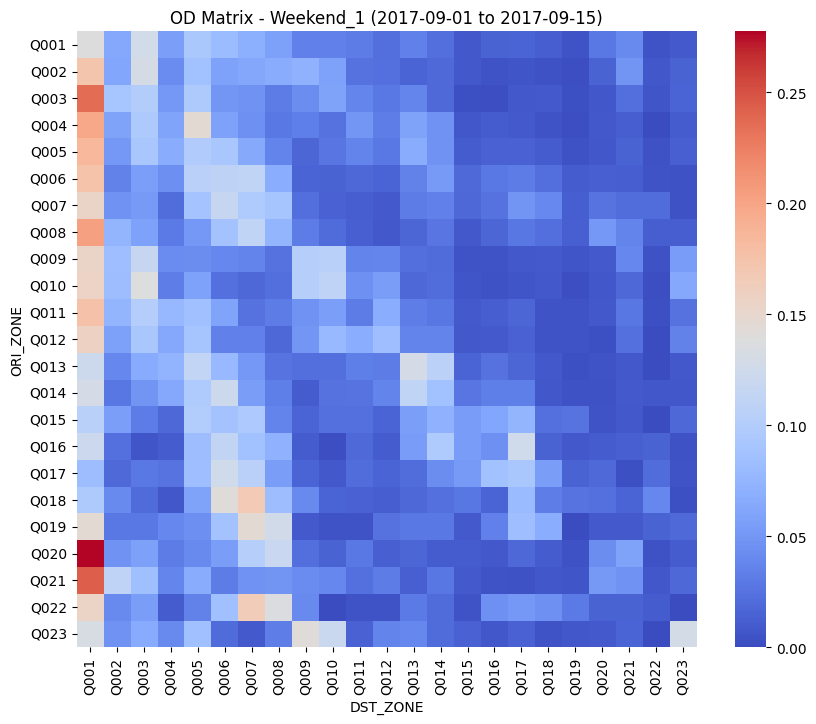

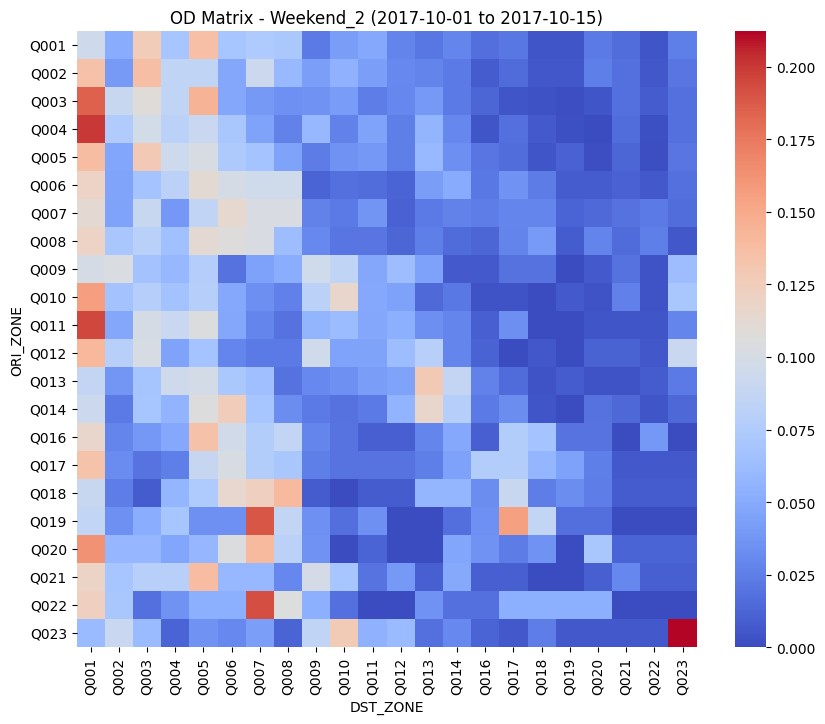

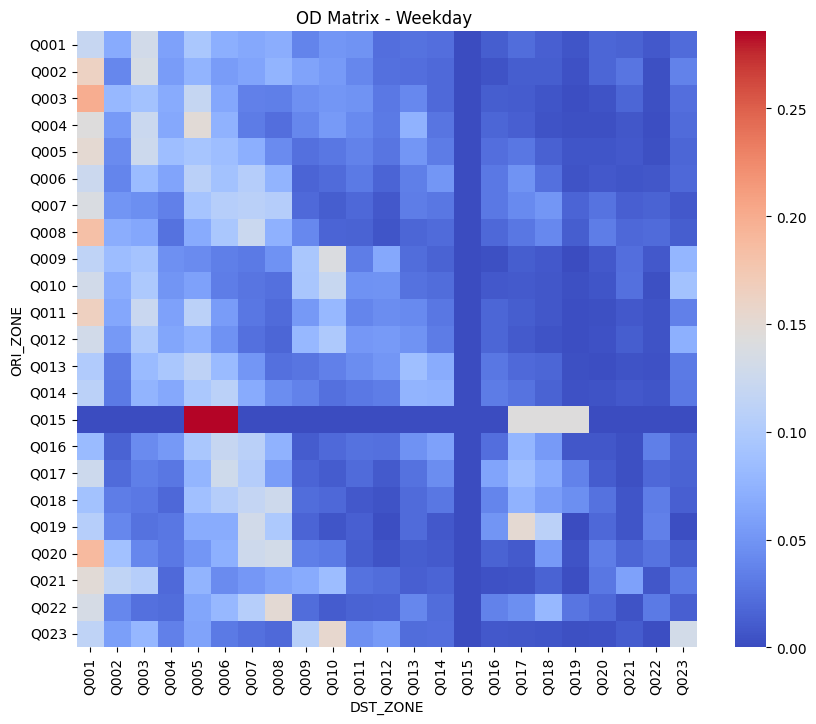

In [106]:
#Assigning zones

#For point d of point 3
df_ictts_PermanentBookings_general = assign_zones(df_ictts_PermanentBookings_general,zones)
df_ictts_enjoy_PermanentBookings_general = assign_zones(df_ictts_enjoy_PermanentBookings_general,zones)


df_ictts_PermanentBookings_weekend  = assign_zones(df_ictts_PermanentBookings_weekend,zones)
df_ictts_PermanentBookings_weekday= assign_zones(df_ictts_PermanentBookings_weekday,zones)

df_ictts_PermanentBookings_night= assign_zones(df_ictts_PermanentBookings_night,zones)
df_ictts_PermanentBookings_day= assign_zones(df_ictts_PermanentBookings_day,zones)

df_ictts_PermanentBookings_normal_week= assign_zones(df_ictts_PermanentBookings_normal_week,zones)
df_ictts_PermanentBookings_normal_week_2= assign_zones(df_ictts_PermanentBookings_normal_week_2,zones)

df_ictts_PermanentBookings_normal_weekend= assign_zones(df_ictts_PermanentBookings_normal_weekend,zones)
df_ictts_PermanentBookings_normal_weekend_2= assign_zones(df_ictts_PermanentBookings_normal_weekend_2,zones)

#enjoy
df_ictts_enjoy_PermanentBookings_weekday= assign_zones(df_ictts_enjoy_PermanentBookings_weekday,zones)


#Pivoting
#For point d of point 3
pivot_table_Permanent_Book_general=pd.pivot_table(df_ictts_PermanentBookings_general,
                            index='ORI_ZONE',
                            columns='DST_ZONE',
                            aggfunc='size',
                            values=None,
                            fill_value=0)
pivot_table_enjoy_Permanent_Book_general=pd.pivot_table(df_ictts_enjoy_PermanentBookings_general,
                            index='ORI_ZONE',
                            columns='DST_ZONE',
                            aggfunc='size',
                            values=None,
                            fill_value=0)


pivot_table_Permanent_Book_weekend = pd.pivot_table(df_ictts_PermanentBookings_weekend,
                            index = 'ORI_ZONE',
                            columns = 'DST_ZONE',
                            aggfunc = 'size',
                             values = None,
                             fill_value = 0)
pivot_table_Permanent_Book_weekday = pd.pivot_table(df_ictts_PermanentBookings_weekday,
                            index = 'ORI_ZONE',
                            columns = 'DST_ZONE',
                            aggfunc = 'size',
                             values = None,
                             fill_value = 0)


pivot_table_Permanent_Book_night = pd.pivot_table(df_ictts_PermanentBookings_night,
                            index = 'ORI_ZONE',
                            columns = 'DST_ZONE',
                            aggfunc = 'size',
                             values = None,
                             fill_value = 0)

pivot_table_Permanent_Book_day = pd.pivot_table(df_ictts_PermanentBookings_day,
                            index = 'ORI_ZONE',
                            columns = 'DST_ZONE',
                            aggfunc = 'size',
                             values = None,
                             fill_value = 0)


pivot_table_Permanent_Book_normal_week=pd.pivot_table(df_ictts_PermanentBookings_normal_week,
                            index='ORI_ZONE',
                            columns='DST_ZONE',
                            aggfunc='size',
                            values=None,
                            fill_value=0)
pivot_table_Permanent_Book_normal_week_2=pd.pivot_table(df_ictts_PermanentBookings_normal_week_2,
                            index='ORI_ZONE',
                            columns='DST_ZONE',
                            aggfunc='size',
                            values=None,
                            fill_value=0)

pivot_table_Permanent_Book_normal_weekend=pd.pivot_table(df_ictts_PermanentBookings_normal_weekend,
                            index='ORI_ZONE',
                            columns='DST_ZONE',
                            aggfunc='size',
                            values=None,
                            fill_value=0)
pivot_table_Permanent_Book_normal_weekend_2=pd.pivot_table(df_ictts_PermanentBookings_normal_weekend_2,
                            index='ORI_ZONE',
                            columns='DST_ZONE',
                            aggfunc='size',
                            values=None,
                            fill_value=0)

#enjoy
pivot_table_enjoy_Permanent_Book_weekday=pd.pivot_table(df_ictts_enjoy_PermanentBookings_weekday,
                            index='ORI_ZONE',
                            columns='DST_ZONE',
                            aggfunc='size',
                            values=None,
                            fill_value=0)

pivot_table_Permanent_Book_general=pivot_table_Permanent_Book_general.div(pivot_table_Permanent_Book_general.sum(axis=1), axis=0)
pivot_table_enjoy_Permanent_Book_general=pivot_table_enjoy_Permanent_Book_general.div(pivot_table_enjoy_Permanent_Book_general.sum(axis=1), axis=0)


pivot_table_Permanent_Book_weekend= pivot_table_Permanent_Book_weekend.div(pivot_table_Permanent_Book_weekend.sum(axis=1), axis=0)
pivot_table_Permanent_Book_weekday= pivot_table_Permanent_Book_weekday.div(pivot_table_Permanent_Book_weekday.sum(axis=1), axis=0)

pivot_table_Permanent_Book_day= pivot_table_Permanent_Book_day.div(pivot_table_Permanent_Book_day.sum(axis=1), axis=0)
pivot_table_Permanent_Book_night= pivot_table_Permanent_Book_night.div(pivot_table_Permanent_Book_night.sum(axis=1), axis=0)

pivot_table_Permanent_Book_normal_week= pivot_table_Permanent_Book_normal_week.div(pivot_table_Permanent_Book_normal_week.sum(axis=1), axis=0)
pivot_table_Permanent_Book_normal_week_2= pivot_table_Permanent_Book_normal_week_2.div(pivot_table_Permanent_Book_normal_week_2.sum(axis=1), axis=0)

pivot_table_Permanent_Book_normal_weekend= pivot_table_Permanent_Book_weekend.div(pivot_table_Permanent_Book_weekend.sum(axis=1), axis=0)
pivot_table_Permanent_Book_normal_weekend_2= pivot_table_Permanent_Book_normal_weekend_2.div(pivot_table_Permanent_Book_normal_weekend_2.sum(axis=1), axis=0)

pivot_table_enjoy_Permanent_Book_weekday = pivot_table_enjoy_Permanent_Book_weekday.div(pivot_table_enjoy_Permanent_Book_weekday.sum(axis=1), axis=0)
##########################################


distance_week = compute_distance(pivot_table_Permanent_Book_weekday, pivot_table_Permanent_Book_weekend, metric='manhattan')
distance_time = compute_distance(pivot_table_Permanent_Book_night, pivot_table_Permanent_Book_day, metric='manhattan')
distance_normal_week_and_week_2= compute_distance(pivot_table_Permanent_Book_normal_week, pivot_table_Permanent_Book_normal_week_2, metric='manhattan')
##Point 2
##### Similar matrices
distance_enjoy_cargo_weekday= compute_distance(pivot_table_enjoy_Permanent_Book_weekday, pivot_table_Permanent_Book_weekday, metric='manhattan')
distance_enjoy_cargo_weekday_eucli= compute_distance(pivot_table_enjoy_Permanent_Book_weekday, pivot_table_Permanent_Book_weekday, metric='euclidean')

###### Dissmilar matrices
distance_enjoy_cargo_weekend_and_night_1= compute_distance(pivot_table_enjoy_Permanent_Book_weekday, pivot_table_Permanent_Book_night, metric='manhattan')
distance_enjoy_cargo_weekend_and_night_2= compute_distance(pivot_table_enjoy_Permanent_Book_weekday, pivot_table_Permanent_Book_night, metric='euclidean')

############################################
plot_heatmap(pivot_table_Permanent_Book_weekday, title="OD Matrix - Weekday")
plot_heatmap(pivot_table_Permanent_Book_weekend, title="OD Matrix - Weekend")

plot_heatmap(pivot_table_Permanent_Book_day, title="OD Matrix - Night")
plot_heatmap(pivot_table_Permanent_Book_night, title="OD Matrix - Day")

plot_heatmap(pivot_table_Permanent_Book_normal_week, title="OD Matrix - Weeek_1 (2017-09-01 to 2017-09-15)")
plot_heatmap(pivot_table_Permanent_Book_normal_week_2, title="OD Matrix - Week_2 (2017-10-01 to 2017-10-15)")

plot_heatmap(pivot_table_Permanent_Book_normal_weekend, title="OD Matrix - Weekend_1 (2017-09-01 to 2017-09-15)")
plot_heatmap(pivot_table_Permanent_Book_normal_weekend_2, title="OD Matrix - Weekend_2 (2017-10-01 to 2017-10-15)")

#enjoy
plot_heatmap(pivot_table_enjoy_Permanent_Book_weekday, title="OD Matrix - Weekday ")

In [107]:
pivot_table_Permanent_Book_normal_week_2.head()

DST_ZONE,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023
ORI_ZONE,,,,,,,,,,,,,,,,,,,,,
Q001,0.111000,0.062812,0.124626,0.068794,0.108342,0.066467,0.070123,0.073114,0.031572,0.047192,...,0.024261,0.0,0.014290,0.016617,0.010967,0.006314,0.019608,0.016949,0.006979,0.023264
Q002,0.147385,0.032488,0.148177,0.070523,0.079239,0.050713,0.072108,0.070523,0.056260,0.055468,...,0.022979,0.0,0.008716,0.013471,0.011886,0.004754,0.022979,0.019017,0.003962,0.030111
Q003,0.191981,0.077358,0.102830,0.083491,0.128302,0.057547,0.034434,0.034434,0.041509,0.044340,...,0.020283,0.0,0.010377,0.008019,0.003774,0.000943,0.005189,0.015566,0.005189,0.023585
Q004,0.156028,0.065248,0.134752,0.062411,0.134043,0.078014,0.031206,0.024113,0.041844,0.043972,...,0.026241,0.0,0.014894,0.010638,0.002128,0.002128,0.000709,0.010638,0.000709,0.024823
Q005,0.155093,0.045833,0.128704,0.085185,0.095370,0.074537,0.072685,0.043519,0.026389,0.031944,...,0.028241,0.0,0.024074,0.024537,0.010648,0.007870,0.003241,0.007407,0.003241,0.019444


# Point 2


In [108]:
distance_time
#day and night

,0
DST_ZONE,
Q001,1.462101
Q002,0.373991
Q003,0.297349
Q004,0.595501
Q005,0.901812
Q006,0.699536
Q007,0.271128
Q008,0.285609
Q009,0.171132


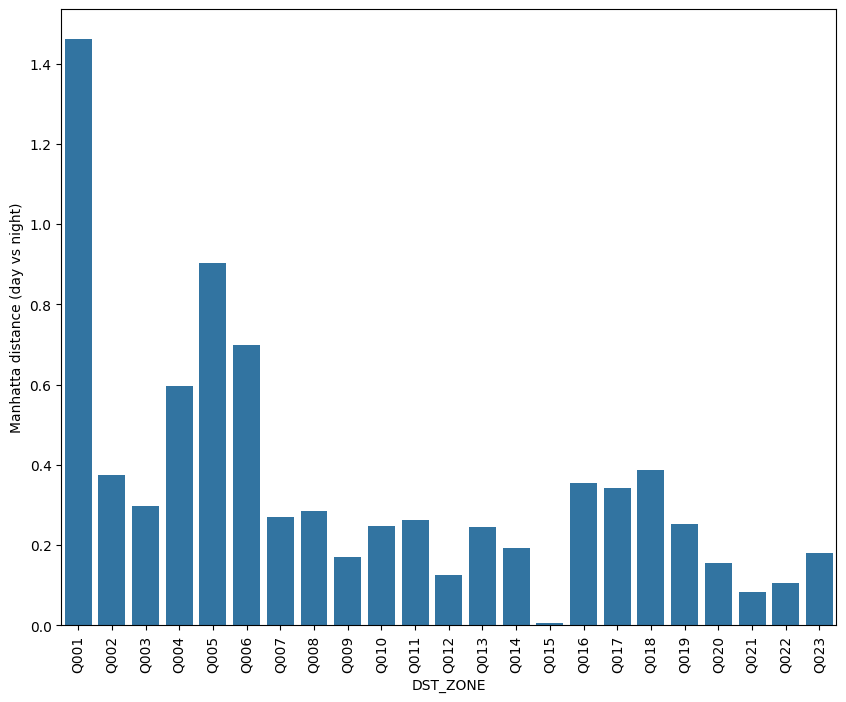

In [109]:

plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_time)
plt.ylabel("Manhatta distance (day vs night)")
plt.show()

In [110]:
distance_week
# week and weekdays

,0
DST_ZONE,
Q001,0.664053
Q002,0.194884
Q003,0.285829
Q004,0.193166
Q005,0.252519
Q006,0.248540
Q007,0.224373
Q008,0.245636
Q009,0.233683


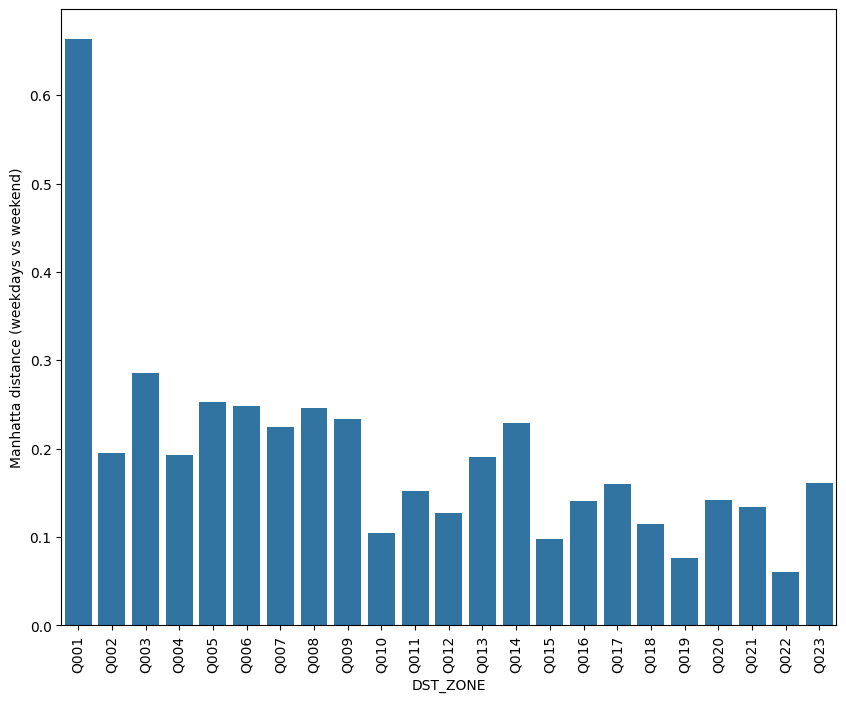

In [111]:

plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_week)
plt.ylabel("Manhatta distance (weekdays vs weekend)")
plt.show()

In [112]:
distance_enjoy_cargo_weekday
#cargo2 and enjoy for weekday

,0
DST_ZONE,
Q001,1.342352
Q002,0.235951
Q003,0.326678
Q004,0.273653
Q005,0.412954
Q006,0.400762
Q007,0.387941
Q008,0.288975
Q009,0.234468


## Similar matrices

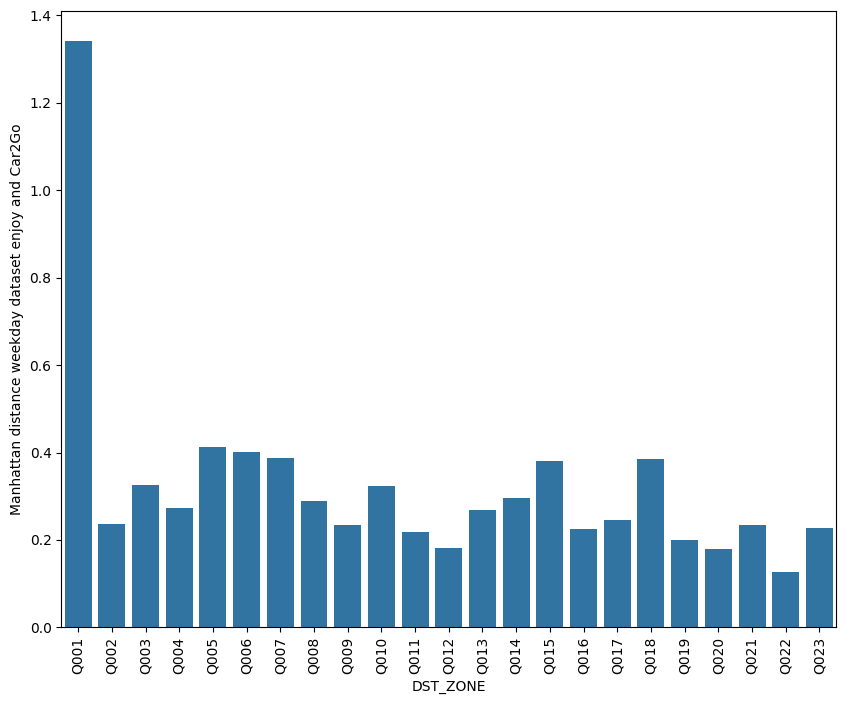

In [113]:

plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_enjoy_cargo_weekday)
plt.ylabel("Manhattan distance weekday dataset enjoy and Car2Go")
plt.show()

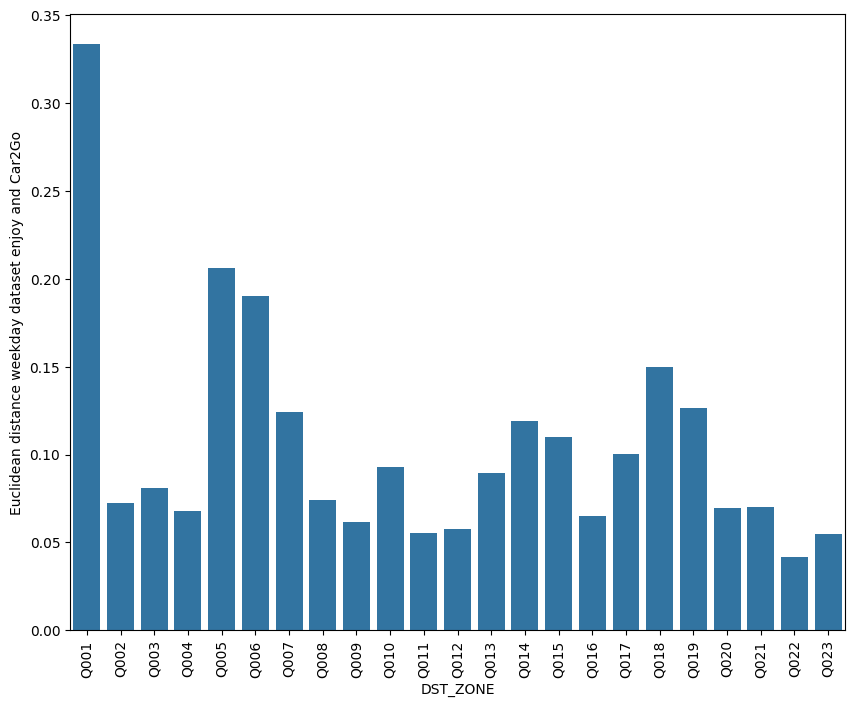

In [114]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_enjoy_cargo_weekday_eucli)
plt.ylabel("Euclidean distance weekday dataset enjoy and Car2Go")
plt.show()

## Dissimilar matrices

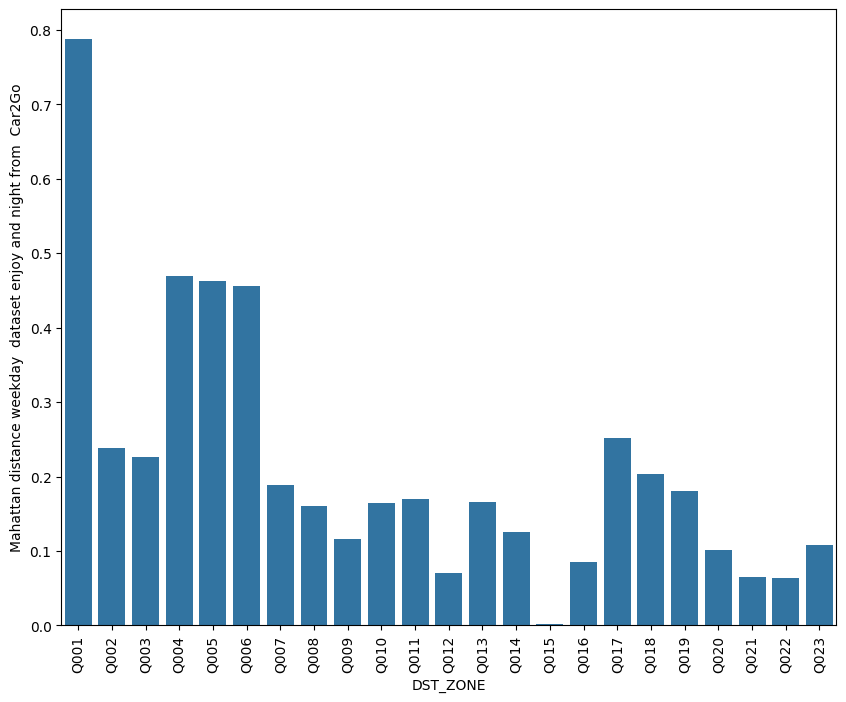

In [115]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_enjoy_cargo_weekend_and_night_1)
plt.ylabel("Mahattan distance weekday  dataset enjoy and night from  Car2Go")
plt.show()

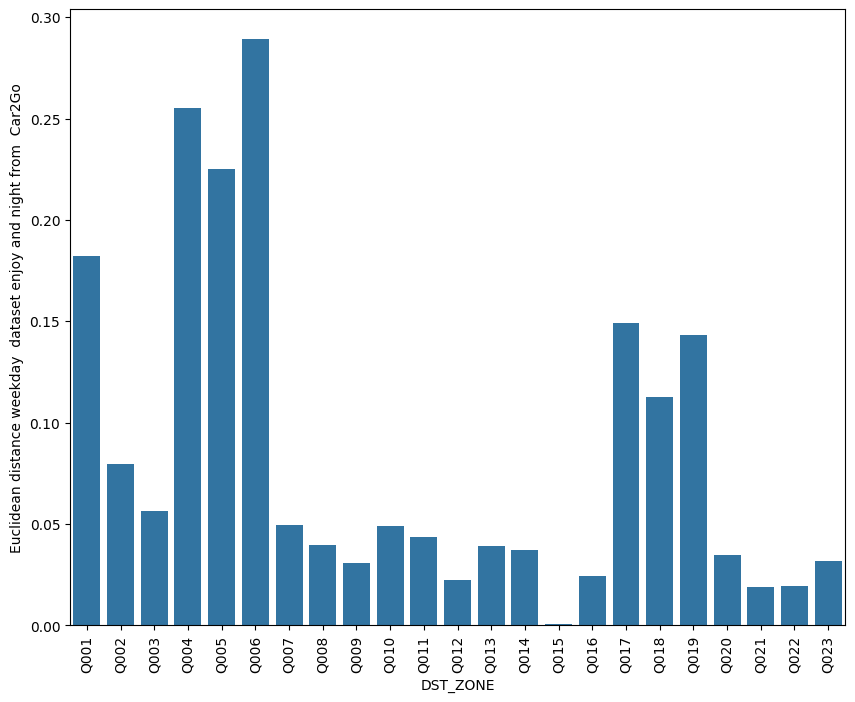

In [116]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_enjoy_cargo_weekend_and_night_2)
plt.ylabel("Euclidean distance weekday  dataset enjoy and night from  Car2Go")
plt.show()

# Point 3

In [117]:

# Create geometries for the points
df_Trips["start_point"] = df_Trips.apply(lambda row: Point(row["lon_start"], row["lat_start"]), axis=1)
df_Trips["stop_point"] = df_Trips.apply(lambda row: Point(row["lon_stop"], row["lat_stop"]), axis=1)
#create gdf
start_gdf = gpd.GeoDataFrame(df_Trips, geometry="start_point", crs="EPSG:4326")
stop_gdf = gpd.GeoDataFrame(df_Trips, geometry="stop_point", crs="EPSG:4326")

#to see if the data is inside of the zones
start_zones = gpd.sjoin(start_gdf, zones, how="left", predicate="intersects") #intersects to see if is inside de poly or in the line
stop_zones = gpd.sjoin(stop_gdf, zones, how="left", predicate="intersects")


#to put the id of the zone
df_Trips["ORI_ZONE"] = start_zones["zone_id"]
df_Trips["DST_ZONE"] = stop_zones["zone_id"]
df_Trips = df_Trips.dropna(subset=['ORI_ZONE', 'DST_ZONE']) #to delete with zone_id= null
df_Trips

# Create geometries for the points
df_Trips["start_point"] = df_Trips.apply(lambda row: Point(row["lon_start"], row["lat_start"]), axis=1)
df_Trips["stop_point"] = df_Trips.apply(lambda row: Point(row["lon_stop"], row["lat_stop"]), axis=1)
#create gdf
start_gdf = gpd.GeoDataFrame(df_Trips, geometry="start_point", crs="EPSG:4326")
stop_gdf = gpd.GeoDataFrame(df_Trips, geometry="stop_point", crs="EPSG:4326")

#to see if the data is inside of the zones
start_zones = gpd.sjoin(start_gdf, zones, how="left", predicate="intersects") #intersects to see if is inside de poly or in the line
stop_zones = gpd.sjoin(stop_gdf, zones, how="left", predicate="intersects")


#to put the id of the zone
df_Trips["ORI_ZONE"] = start_zones["zone_id"]
df_Trips["DST_ZONE"] = stop_zones["zone_id"]
df_Trips = df_Trips.dropna(subset=['ORI_ZONE', 'DST_ZONE']) #to delete with zone_id= null
df_Trips


,id_veicolo,id_viaggio,istante_start,lat_start,lon_start,istante_stop,lat_stop,lon_stop,commerciale,eta_approx,genere,start_point,stop_point,ORI_ZONE,DST_ZONE
0,1,2,2024-08-27 21:15:03,45.069,7.698,2024-08-27 21:16:05,45.069,7.698,N,47,M,POINT (7.698 45.069),POINT (7.698 45.069),Q008,Q008
1,1,4,2024-08-27 21:22:47,45.069,7.698,2024-08-27 21:32:03,45.083,7.675,N,47,M,POINT (7.698 45.069),POINT (7.675 45.083),Q008,Q006
2,1,5,2024-08-28 08:16:42,45.083,7.675,2024-08-28 08:29:07,45.067,7.688,N,47,M,POINT (7.675 45.083),POINT (7.688 45.067),Q006,Q001
3,1,6,2024-08-28 11:47:37,45.068,7.687,2024-08-28 11:54:02,45.083,7.675,N,47,M,POINT (7.687 45.068),POINT (7.675 45.083),Q001,Q006
4,1,7,2024-08-29 12:22:22,45.083,7.675,2024-08-29 12:31:44,45.077,7.668,N,47,M,POINT (7.675 45.083),POINT (7.668 45.077),Q006,Q006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545373,37949,7,2024-09-02 06:56:54,45.076,7.682,2024-09-02 06:59:12,45.076,7.681,N,48,M,POINT (7.682 45.076),POINT (7.681 45.076),Q007,Q007
545374,37949,10,2024-09-02 07:20:00,45.076,7.681,2024-09-02 07:22:04,45.076,7.682,N,48,M,POINT (7.681 45.076),POINT (7.682 45.076),Q007,Q007
545375,37949,13,2024-09-02 07:42:54,45.076,7.682,2024-09-02 07:44:00,45.076,7.682,N,48,M,POINT (7.682 45.076),POINT (7.682 45.076),Q007,Q007
545376,37949,15,2024-09-02 14:05:15,45.076,7.682,2024-09-02 14:07:03,45.076,7.682,N,48,M,POINT (7.682 45.076),POINT (7.682 45.076),Q007,Q007


In [118]:
df_Trips.head()

,id_veicolo,id_viaggio,istante_start,lat_start,lon_start,istante_stop,lat_stop,lon_stop,commerciale,eta_approx,genere,start_point,stop_point,ORI_ZONE,DST_ZONE
0,1,2,2024-08-27 21:15:03,45.069,7.698,2024-08-27 21:16:05,45.069,7.698,N,47,M,POINT (7.698 45.069),POINT (7.698 45.069),Q008,Q008
1,1,4,2024-08-27 21:22:47,45.069,7.698,2024-08-27 21:32:03,45.083,7.675,N,47,M,POINT (7.698 45.069),POINT (7.675 45.083),Q008,Q006
2,1,5,2024-08-28 08:16:42,45.083,7.675,2024-08-28 08:29:07,45.067,7.688,N,47,M,POINT (7.675 45.083),POINT (7.688 45.067),Q006,Q001
3,1,6,2024-08-28 11:47:37,45.068,7.687,2024-08-28 11:54:02,45.083,7.675,N,47,M,POINT (7.687 45.068),POINT (7.675 45.083),Q001,Q006
4,1,7,2024-08-29 12:22:22,45.083,7.675,2024-08-29 12:31:44,45.077,7.668,N,47,M,POINT (7.675 45.083),POINT (7.668 45.077),Q006,Q006


**Filter sex**

In [119]:
df_IMQ_male = df_IMQ[df_IMQ['GENDER'] == 1]
df_IMQ_female = df_IMQ[df_IMQ['GENDER'] == 2]

df_Trips_male = df_Trips[df_Trips['genere'] == "M"]
df_Trips_female = df_Trips[df_Trips['genere'] == "F"]

In [120]:

#PIVOTING
pivot_table_IMQ = pd.pivot_table(df_IMQ,
                            index = 'ORI_ZONE',
                            columns = 'DST_ZONE',
                            aggfunc = 'size',
                             values = None,
                             fill_value = 0)



pivot_table_IMQ_male = pd.pivot_table(df_IMQ_male,
                            index = 'ORI_ZONE',
                            columns = 'DST_ZONE',
                            aggfunc = 'size',
                             values = None,
                             fill_value = 0)
pivot_table_IMQ_female = pd.pivot_table(df_IMQ_female,
                            index = 'ORI_ZONE',
                            columns = 'DST_ZONE',
                            aggfunc = 'size',
                             values = None,
                             fill_value = 0)




pivot_table_Trips = pd.pivot_table(df_Trips,
                            index = 'ORI_ZONE',
                            columns = 'DST_ZONE',
                            aggfunc = 'size',
                             values = None,
                             fill_value = 0)

pivot_table_Trips_male = pd.pivot_table(df_Trips_male,
                            index = 'ORI_ZONE',
                            columns = 'DST_ZONE',
                            aggfunc = 'size',
                             values = None,
                             fill_value = 0)
pivot_table_Trips_female = pd.pivot_table(df_Trips_female,
                            index = 'ORI_ZONE',
                            columns = 'DST_ZONE',
                            aggfunc = 'size',
                             values = None,
                             fill_value = 0)

# normalizing
pivot_table_IMQ = pivot_table_IMQ.div(pivot_table_IMQ.sum(axis=1), axis=0)
pivot_table_IMQ_male = pivot_table_IMQ_male.div(pivot_table_IMQ_male.sum(axis=1), axis=0)
pivot_table_IMQ_female = pivot_table_IMQ_female.div(pivot_table_IMQ_female.sum(axis=1), axis=0)


pivot_table_Trips = pivot_table_Trips.div(pivot_table_Trips.sum(axis=1), axis=0)
pivot_table_Trips_male = pivot_table_Trips_male.div(pivot_table_Trips_male.sum(axis=1), axis=0)
pivot_table_Trips_female = pivot_table_Trips_female.div(pivot_table_Trips_female.sum(axis=1), axis=0)

In [121]:
#pivot_table_enjoy_Permanent_Book

In [122]:
#pivot_table_Permanent_Book

In [123]:
pivot_table_IMQ.head()


DST_ZONE,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023
ORI_ZONE,,,,,,,,,,,,,,,,,,,,,
Q001,0.227410,0.056727,0.065763,0.016064,0.046687,0.066265,0.069277,0.053213,0.034137,0.029618,...,0.033635,0.017570,0.024598,0.038153,0.028112,0.017570,0.012048,0.026606,0.025100,0.021084
Q002,0.182708,0.257749,0.055465,0.021207,0.030995,0.027732,0.030995,0.032626,0.096248,0.026101,...,0.017945,0.009788,0.013051,0.014682,0.011419,0.009788,0.009788,0.014682,0.047308,0.026101
Q003,0.143982,0.040495,0.310461,0.043870,0.066367,0.034871,0.031496,0.008999,0.032621,0.042745,...,0.019123,0.010124,0.012373,0.015748,0.008999,0.007874,0.005624,0.005624,0.008999,0.017998
Q004,0.067395,0.021858,0.072860,0.265938,0.132969,0.036430,0.021858,0.016393,0.029144,0.016393,...,0.030965,0.007286,0.010929,0.012750,0.009107,0.007286,0.001821,0.009107,0.003643,0.018215
Q005,0.102181,0.022962,0.064294,0.084960,0.280138,0.091848,0.030999,0.019518,0.021814,0.009185,...,0.043628,0.013777,0.009185,0.016073,0.004592,0.006889,0.001148,0.008037,0.012629,0.020666


In [124]:
pivot_table_Trips.head()

DST_ZONE,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023
ORI_ZONE,,,,,,,,,,,,,,,,,,,,,
Q001,0.420235,0.046229,0.082336,0.023416,0.052173,0.052615,0.046028,0.036589,0.024299,0.020243,...,0.021809,0.008716,0.010001,0.014419,0.011125,0.008515,0.010684,0.039802,0.003735,0.009559
Q002,0.094764,0.416282,0.082382,0.019989,0.025815,0.022821,0.022174,0.025977,0.088371,0.036336,...,0.013676,0.004775,0.004127,0.007688,0.005665,0.004046,0.008578,0.050336,0.002185,0.016833
Q003,0.088576,0.042736,0.444850,0.056324,0.053598,0.027344,0.017656,0.009520,0.033593,0.044791,...,0.017069,0.005871,0.006752,0.007172,0.004362,0.003523,0.002936,0.018915,0.000923,0.014930
Q004,0.027748,0.012311,0.064160,0.394716,0.103414,0.026374,0.012027,0.005682,0.016289,0.022539,...,0.038354,0.008239,0.007908,0.008760,0.004404,0.004404,0.000805,0.006534,0.001042,0.013779
Q005,0.057212,0.014152,0.053469,0.096055,0.361251,0.086248,0.027659,0.008517,0.011959,0.015142,...,0.061470,0.010238,0.016174,0.016045,0.008431,0.005979,0.001290,0.006840,0.001377,0.011227


## Similarity

In [125]:
distance_IMQT_UNIPOLT= compute_distance(pivot_table_IMQ, pivot_table_Trips, metric='manhattan')

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


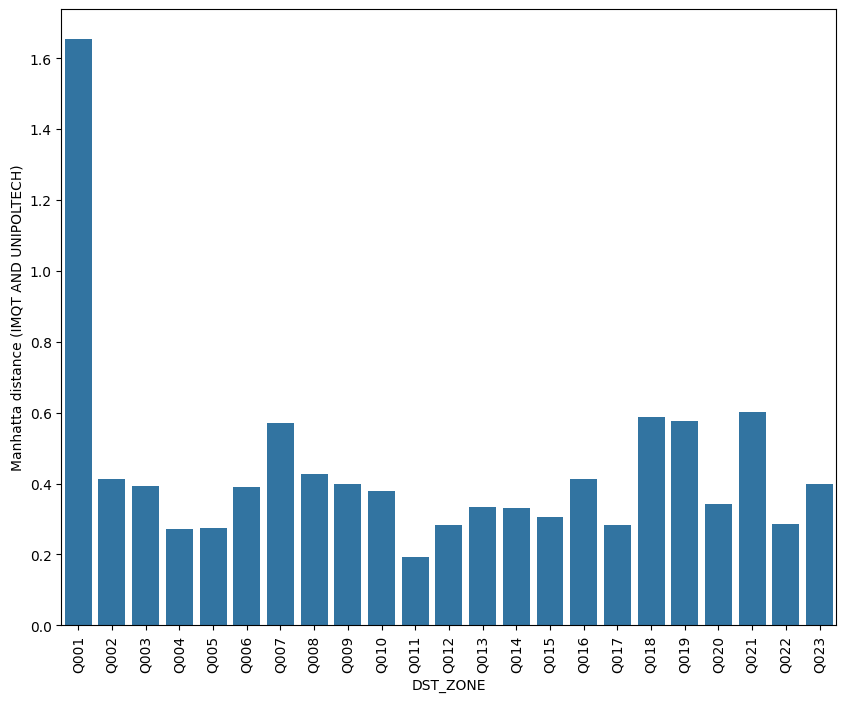

In [126]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_IMQT_UNIPOLT)
plt.ylabel("Manhatta distance (IMQT AND UNIPOLTECH)")
plt.show()

## Point a

### Female

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


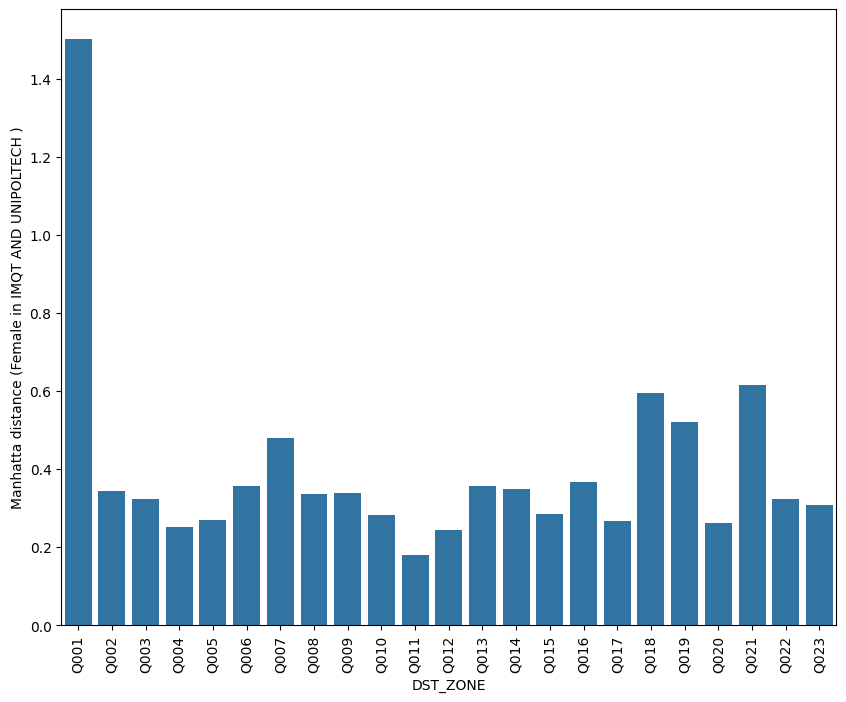

In [127]:
distance_female= compute_distance(pivot_table_IMQ_female, pivot_table_Trips_female, metric='manhattan')
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_female)
plt.ylabel("Manhatta distance (Female in IMQT AND UNIPOLTECH )")
plt.show()

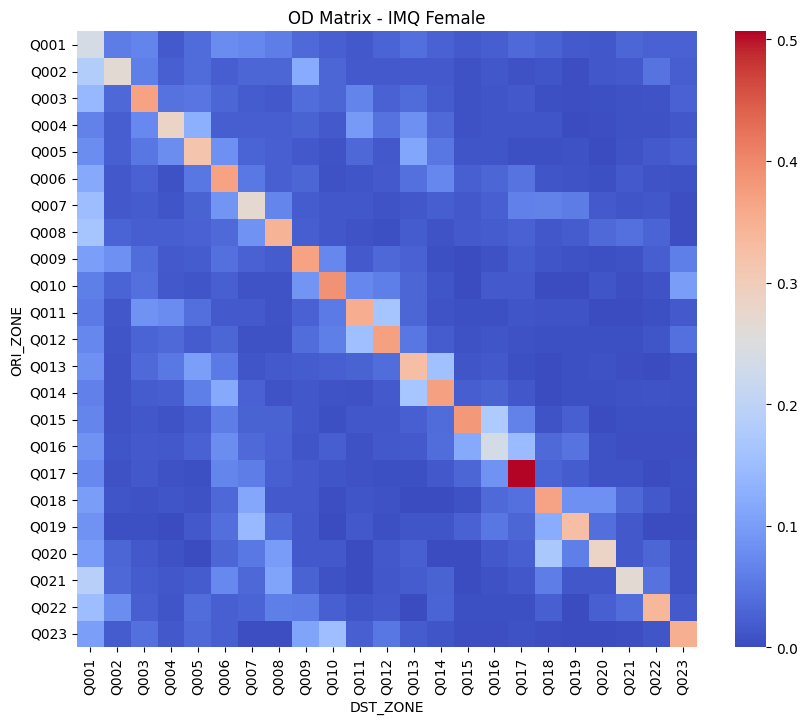

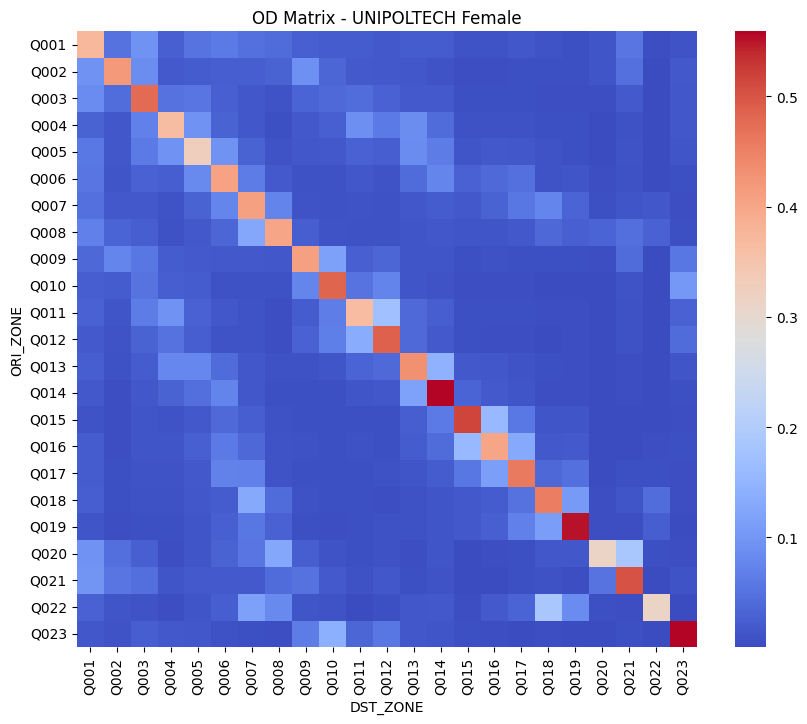

In [128]:
plot_heatmap(pivot_table_IMQ_female, title="OD Matrix - IMQ Female")
plot_heatmap(pivot_table_Trips_female, title="OD Matrix - UNIPOLTECH Female")

### Male

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


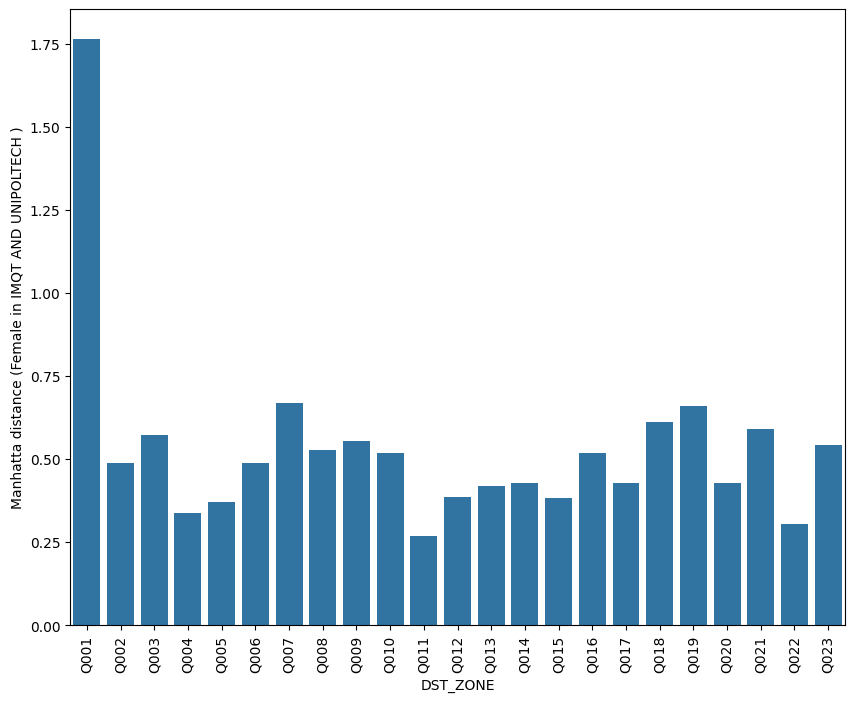

In [129]:
distance_male= compute_distance(pivot_table_IMQ_male, pivot_table_Trips_male, metric='manhattan')
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_male)
plt.ylabel("Manhatta distance (Female in IMQT AND UNIPOLTECH )")
plt.show()

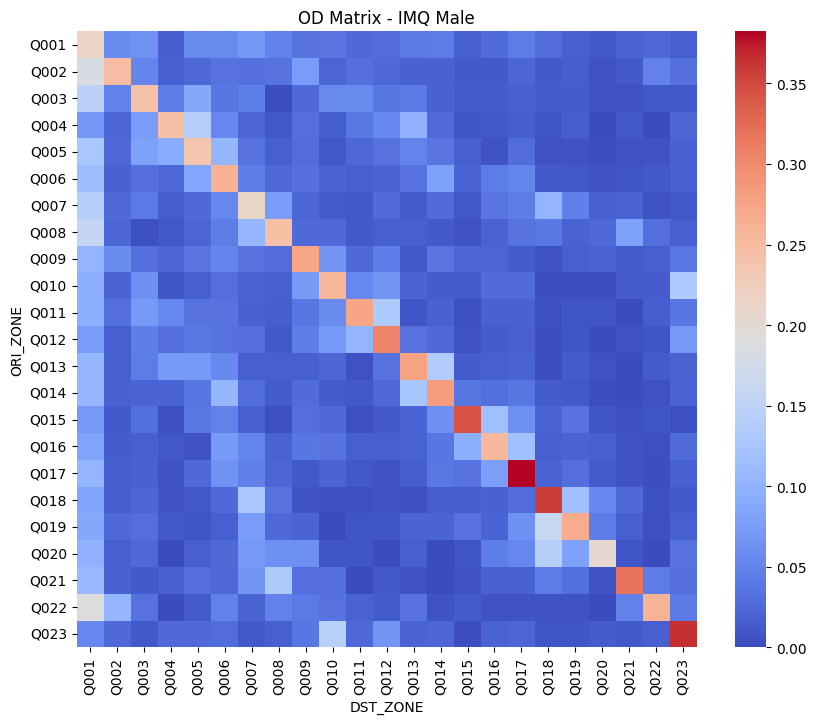

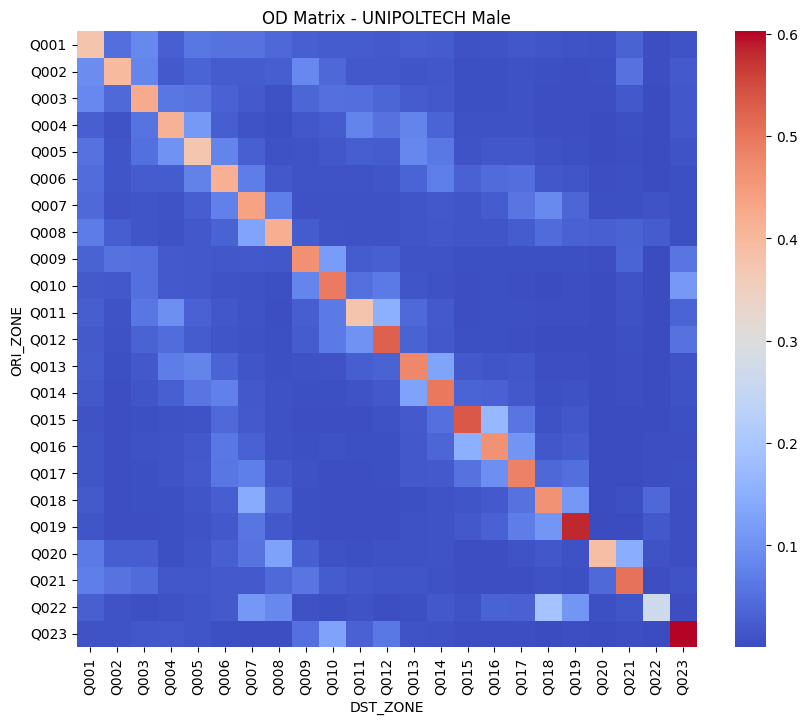

In [130]:
plot_heatmap(pivot_table_IMQ_male, title="OD Matrix - IMQ Male")
plot_heatmap(pivot_table_Trips_male, title="OD Matrix - UNIPOLTECH Male")

## Point B (IMQS)

<Axes: xlabel='AGE'>

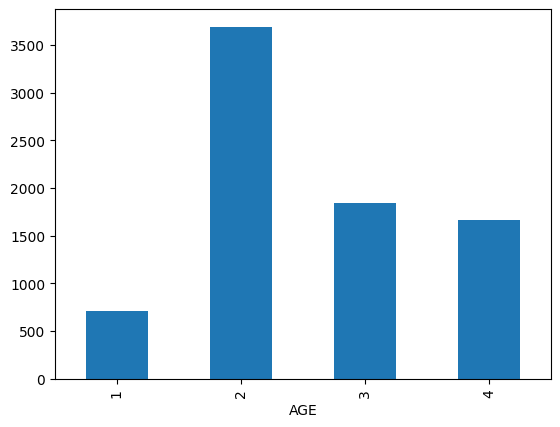

In [131]:
df_IMQ_male.groupby("AGE")["GENDER"].count().plot(kind="bar")

In [132]:
#Filter
df_IMQ_female_1= df_IMQ_female[df_IMQ_female["AGE"] == 1]
df_IMQ_female_2= df_IMQ_female[df_IMQ_female["AGE"] == 2]
df_IMQ_female_3= df_IMQ_female[df_IMQ_female["AGE"] == 3]
df_IMQ_female_4= df_IMQ_female[df_IMQ_female["AGE"] == 4]

df_IMQ_male_1= df_IMQ_male[df_IMQ_male["AGE"] == 1]
df_IMQ_male_2= df_IMQ_male[df_IMQ_male["AGE"] == 2]
df_IMQ_male_3= df_IMQ_male[df_IMQ_male["AGE"] == 3]
df_IMQ_male_4= df_IMQ_male[df_IMQ_male["AGE"] == 4]


def pivot_table(dataset):
    pivot_table = pd.pivot_table(dataset,
                            index = 'ORI_ZONE',
                            columns = 'DST_ZONE',
                            aggfunc = 'size',
                             values = None,
                             fill_value = 0)
    return pivot_table

#Pivot
pivot_table_IMQ_female_1 = pivot_table(df_IMQ_female_1)
pivot_table_IMQ_female_2 = pivot_table(df_IMQ_female_2)
pivot_table_IMQ_female_3 = pivot_table(df_IMQ_female_3)
pivot_table_IMQ_female_4 = pivot_table(df_IMQ_female_4)

pivot_table_IMQ_male_1 = pivot_table(df_IMQ_male_1)
pivot_table_IMQ_male_2 = pivot_table(df_IMQ_male_2)
pivot_table_IMQ_male_3 = pivot_table(df_IMQ_male_3)
pivot_table_IMQ_male_4 = pivot_table(df_IMQ_male_4)

#Normalizer
pivot_table_IMQ_female_1 = pivot_table_IMQ_female_1.div(pivot_table_IMQ_female_1.sum(axis=1), axis=0)
pivot_table_IMQ_female_2 = pivot_table_IMQ_female_2.div(pivot_table_IMQ_female_2.sum(axis=1), axis=0)
pivot_table_IMQ_female_3 = pivot_table_IMQ_female_3.div(pivot_table_IMQ_female_3.sum(axis=1), axis=0)
pivot_table_IMQ_female_4 = pivot_table_IMQ_female_4.div(pivot_table_IMQ_female_4.sum(axis=1), axis=0)

pivot_table_IMQ_male_1 = pivot_table_IMQ_male_1.div(pivot_table_IMQ_male_1.sum(axis=1), axis=0)
pivot_table_IMQ_male_2 = pivot_table_IMQ_male_2.div(pivot_table_IMQ_male_2.sum(axis=1), axis=0)
pivot_table_IMQ_male_3 = pivot_table_IMQ_male_3.div(pivot_table_IMQ_male_3.sum(axis=1), axis=0)
pivot_table_IMQ_male_4 = pivot_table_IMQ_male_4.div(pivot_table_IMQ_male_4.sum(axis=1), axis=0)



#Distance
distance_IMQT_female_1= compute_distance(pivot_table_IMQ_female_1, pivot_table_IMQ_female_2 , metric='manhattan')
distance_IMQT_female_2= compute_distance(pivot_table_IMQ_female_3, pivot_table_IMQ_female_4 , metric='manhattan')

distance_IMQT_male_1= compute_distance(pivot_table_IMQ_male_1, pivot_table_IMQ_male_2 , metric='manhattan')
distance_IMQT_male_2= compute_distance(pivot_table_IMQ_male_3, pivot_table_IMQ_male_4 , metric='manhattan')




/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


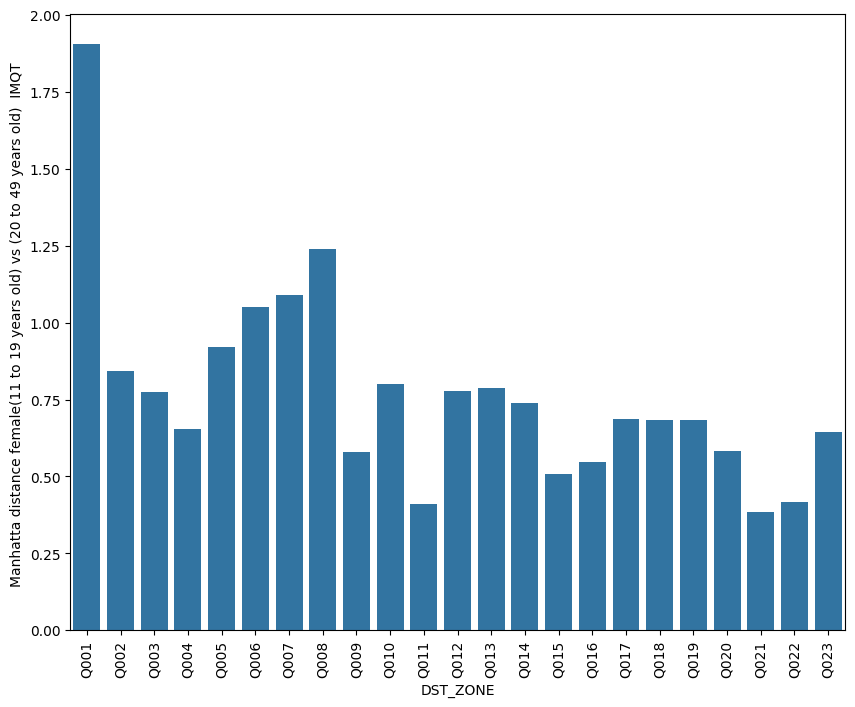

In [133]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_IMQT_female_1)
plt.ylabel("Manhatta distance female(11 to 19 years old) vs (20 to 49 years old)  IMQT ")
plt.show()

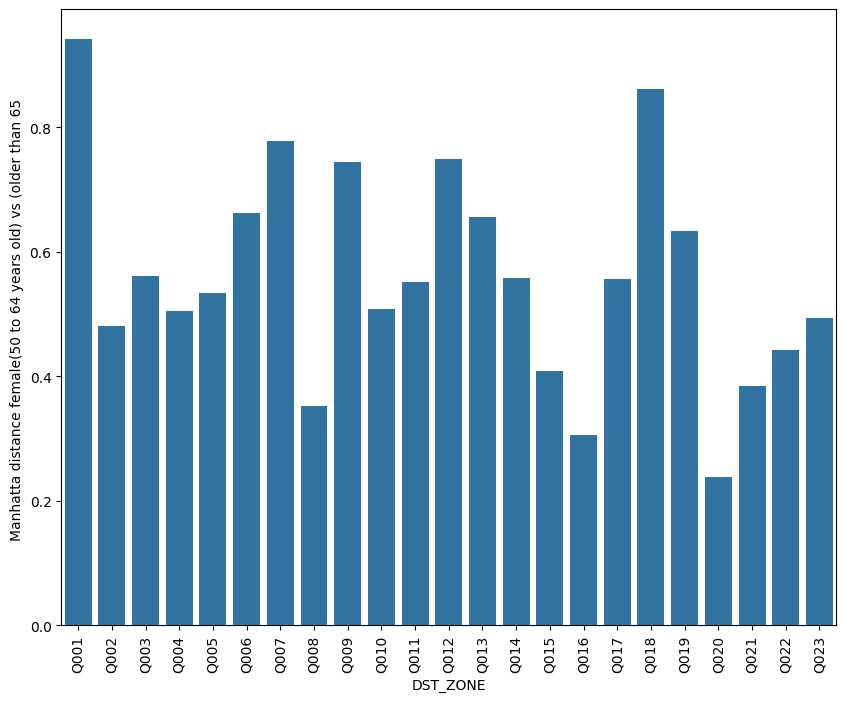

In [134]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_IMQT_female_2)
plt.ylabel("Manhatta distance female(50 to 64 years old) vs (older than 65 ")
plt.show()

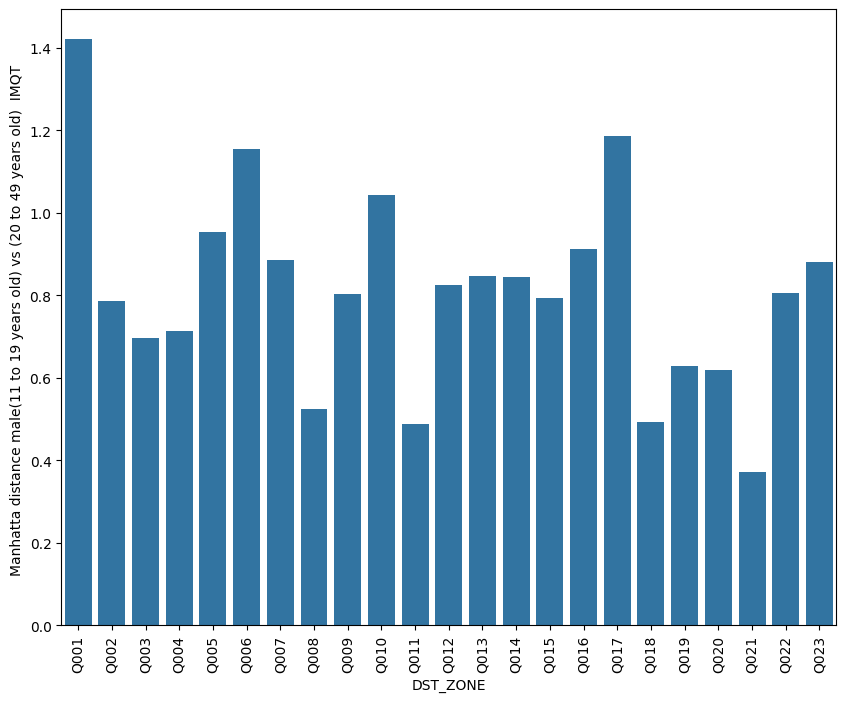

In [135]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_IMQT_male_1)
plt.ylabel("Manhatta distance male(11 to 19 years old) vs (20 to 49 years old)  IMQT ")
plt.show()

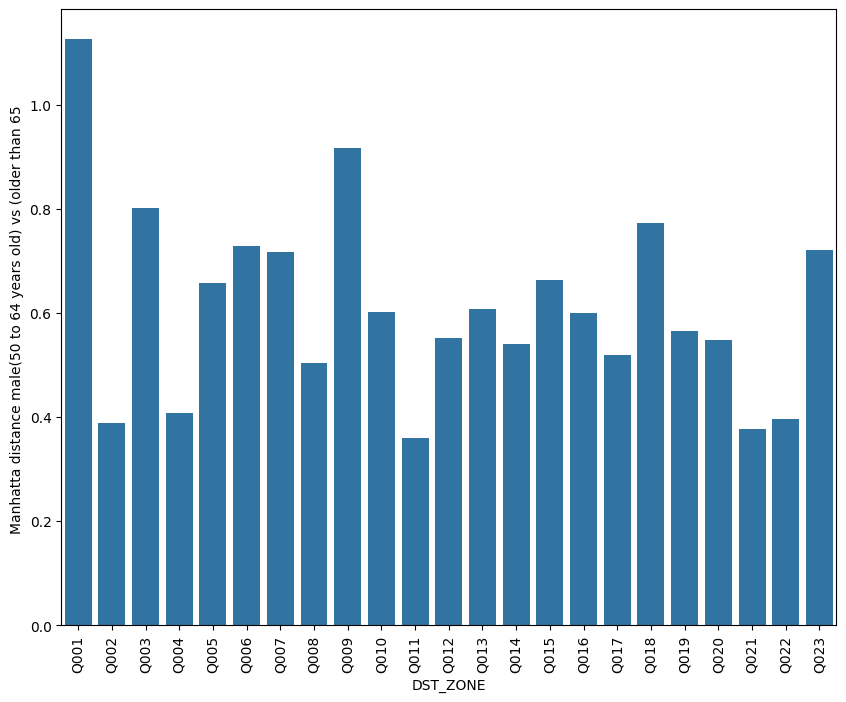

In [136]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(data=distance_IMQT_male_2)
plt.ylabel("Manhatta distance male(50 to 64 years old) vs (older than 65 ")
plt.show()

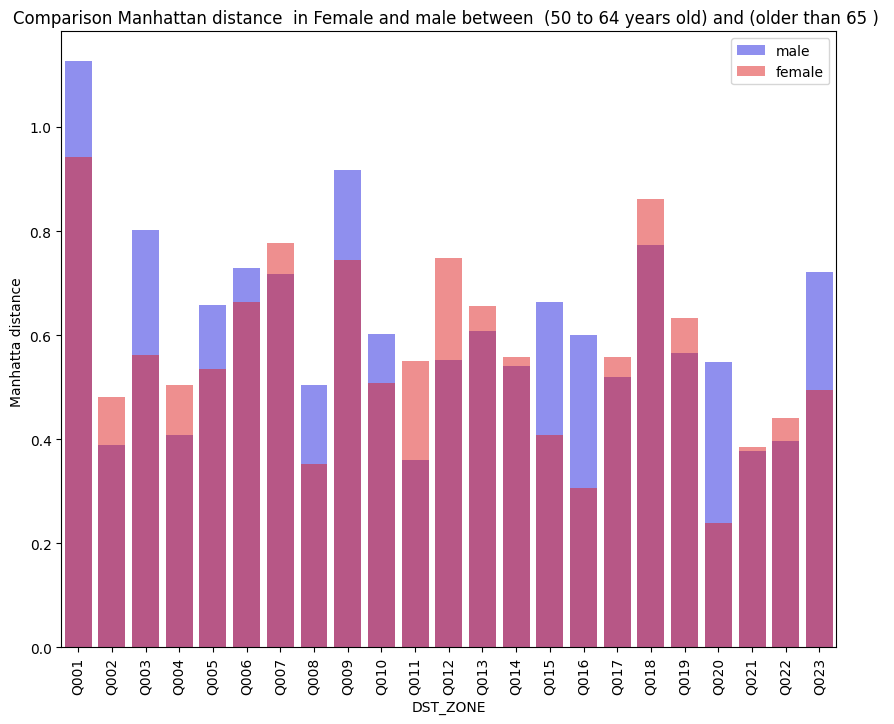

In [137]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)

plt.title('Comparison Manhattan distance  in Female and male between  (50 to 64 years old) and (older than 65 ) ')
sns.barplot(data=distance_IMQT_male_2,alpha=0.5,color='blue',label="male")
sns.barplot(data=distance_IMQT_female_2,alpha=0.5,color='red',label="female")
plt.ylabel("Manhatta distance ")
plt.legend()

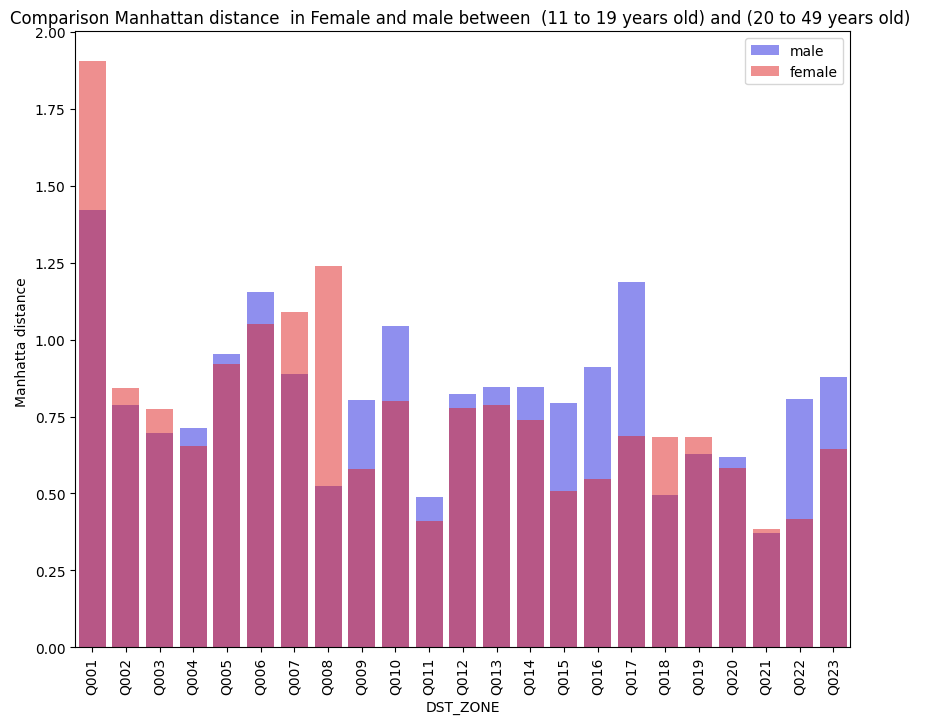

In [138]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)

plt.title('Comparison Manhattan distance  in Female and male between  (11 to 19 years old) and (20 to 49 years old) ')
sns.barplot(data=distance_IMQT_male_1,alpha=0.5,color='blue',label="male")
sns.barplot(data=distance_IMQT_female_1,alpha=0.5,color='red',label="female")
plt.ylabel("Manhatta distance ")
plt.legend()

## Point C

In [141]:
df_Trips.groupby(["commerciale","eta_approx","genere"])["genere"].count().rename("count")

commerciale  eta_approx  genere
N            3           F             8
             18          F            34
                         M            39
             19          F            69
                         M           501
                                   ...  
             96          F            19
                         M            12
             97          M             7
             98          F            94
S            0           _         38800
Name: count, Length: 161, dtype: int64

In [151]:
df_IMQ.groupby(["MOTIVATION","GENDER","AGE"])["GENDER"].count().rename("count").sort_values(ascending=False).head(1)

,,,count
MOTIVATION,GENDER,AGE,
8,2,2,1869


## Point D

In [143]:
pivot_table_IMQ

DST_ZONE,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023
ORI_ZONE,,,,,,,,,,,,,,,,,,,,,
Q001,0.227410,0.056727,0.065763,0.016064,0.046687,0.066265,0.069277,0.053213,0.034137,0.029618,...,0.033635,0.017570,0.024598,0.038153,0.028112,0.017570,0.012048,0.026606,0.025100,0.021084
Q002,0.182708,0.257749,0.055465,0.021207,0.030995,0.027732,0.030995,0.032626,0.096248,0.026101,...,0.017945,0.009788,0.013051,0.014682,0.011419,0.009788,0.009788,0.014682,0.047308,0.026101
Q003,0.143982,0.040495,0.310461,0.043870,0.066367,0.034871,0.031496,0.008999,0.032621,0.042745,...,0.019123,0.010124,0.012373,0.015748,0.008999,0.007874,0.005624,0.005624,0.008999,0.017998
Q004,0.067395,0.021858,0.072860,0.265938,0.132969,0.036430,0.021858,0.016393,0.029144,0.016393,...,0.030965,0.007286,0.010929,0.012750,0.009107,0.007286,0.001821,0.009107,0.003643,0.018215
Q005,0.102181,0.022962,0.064294,0.084960,0.280138,0.091848,0.030999,0.019518,0.021814,0.009185,...,0.043628,0.013777,0.009185,0.016073,0.004592,0.006889,0.001148,0.008037,0.012629,0.020666
Q006,0.116221,0.016722,0.028428,0.015050,0.065217,0.322742,0.050167,0.024247,0.031773,0.013378,...,0.074415,0.021739,0.035953,0.049331,0.011706,0.009197,0.005853,0.013378,0.010033,0.012542
Q007,0.145089,0.020089,0.030134,0.013393,0.025670,0.071429,0.241071,0.071429,0.021205,0.013393,...,0.024554,0.012277,0.030134,0.053571,0.082589,0.051339,0.017857,0.015625,0.010045,0.005580
Q008,0.160714,0.026786,0.013393,0.016369,0.023810,0.038690,0.093750,0.300595,0.023810,0.019345,...,0.010417,0.011905,0.019345,0.028274,0.025298,0.019345,0.031250,0.059524,0.029762,0.008929
Q009,0.102564,0.070513,0.035897,0.019231,0.026923,0.046154,0.029487,0.023077,0.326923,0.067949,...,0.019231,0.010256,0.014103,0.016667,0.008974,0.011538,0.011538,0.010256,0.019231,0.051282


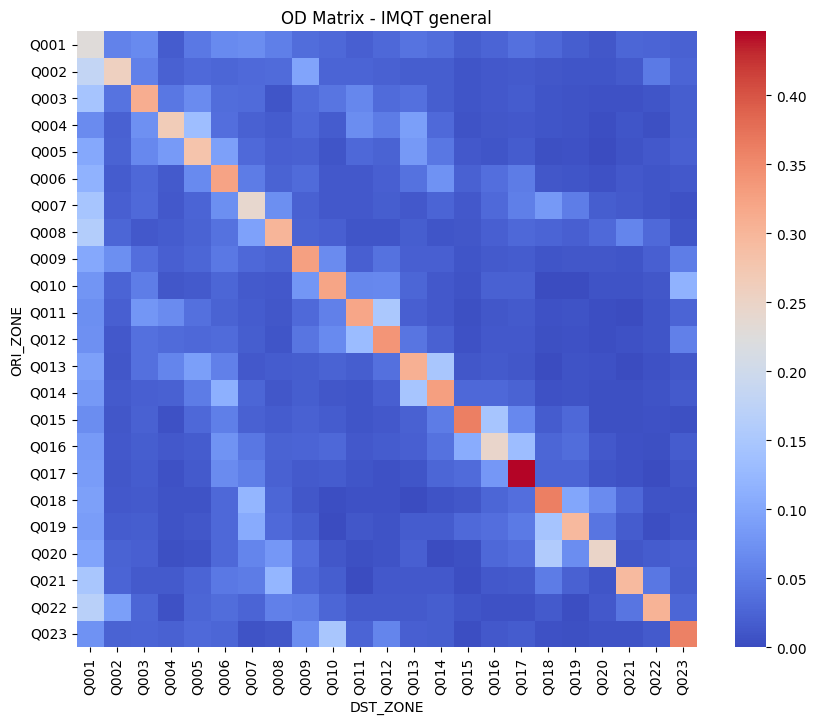

In [147]:
plot_heatmap(pivot_table_IMQ, title="OD Matrix - IMQT general")

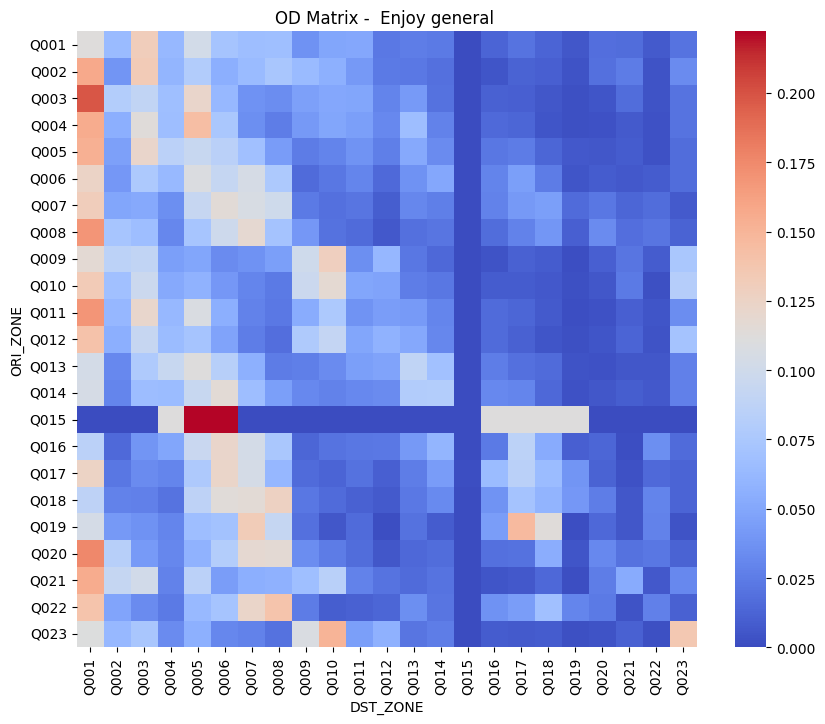

In [145]:
#enjoy
plot_heatmap(pivot_table_enjoy_Permanent_Book_general, title="OD Matrix -  Enjoy general ")

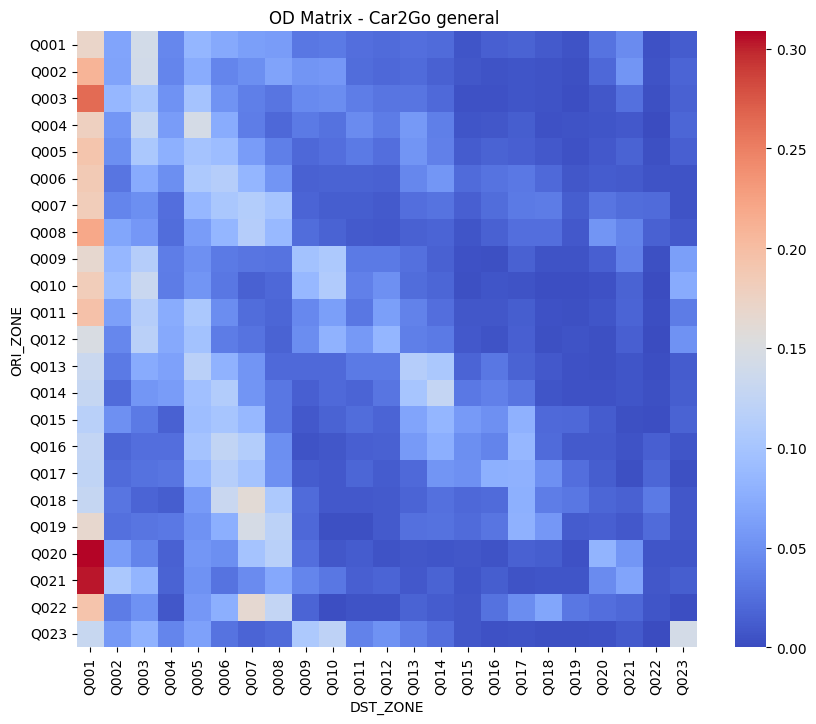

In [148]:
plot_heatmap(pivot_table_Permanent_Book_general, title="OD Matrix - Car2Go general ")